# Recomendação via Fatorização de matrizes (Matrix factorization)

Num projeto anterior, fizemos o completamento de matrizes (por exemplo para sistemas de recomendação como o Netflix) usando uma abordagem *convexa*: algoritmos de otimização de um problema com regularização convexa (norma nuclear). 

Uma segunda abordagem bem sucedida é estimar a matriz não observada $X^*$ resolvendo o problema:

$$\min_X f(X)=f(U,V):=\frac 1 2 \|U V^\top - Y\|^2_F,$$

onde $Y\in {\mathbb R}^{m\times n}$ é a matriz observada, $U\in {\mathbb R}^{m\times r}$, $V\in {\mathbb R}^{n\times r}$ and $r<\min\{m,n\}$. O gradiente é dado por 

$$
\nabla f(X) = [(UV^\top -Y) V, (UV^\top-Y)^\top U].
$$

Note que diferentemente do caso convexo (onde tínhamos a penalização $\lambda>0$ da norma nuclear como hyper-parâmetro), nesta abordagem temos uma estimativa do posto $r$ como hyper-parâmetro. A idéia aqui é "regularizar" a solução com posto $r$ impondo a fatorização $U V^\top$. Do ponto de vista computacional, a diferença é que o problema é não convexo. Entretanto, algoritmos de otimização iterativos funcionam bem na prática. 

Iremos utilizar os dados [Movielens 100K dataset](https://grouplens.org/datasets/movielens/100k/). Em particular usamos o arquivo `u.data` desta pasta, gravado em `~/datasets`. Este arquivo tem avaliações de filmes de 943 usuários e 1682 filmes. Começamos carregando alguns módulos necessários:

In [1]:
#Chamando módulos necessários:
import cupy as np
import scipy.linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.sparse as spr
import scipy.sparse.linalg as spr_LA

À seguir iremos carregar os dados e escrevê-los numa matriz esparsa $Y$.

In [22]:
#Carregando dados:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('datasets/u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

#Criando a matriz Y de avaliações:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

Y = ratings
m, n = Y.shape
print("As dimensões de Y são:", m, n)

As dimensões de Y são: 943 1682


# Exercício 1: Funções auxiliares

1. Construa uma função `f()` que toma $X=(U,V)$ e retorna o valor funcional $f(X)=\frac 1 2 \|U V^\top - Y\|^2_F$.
2. Construa uma função `df()` que toma $X=(U,V)$ e retorna o gradiente $\nabla f(X) = [(UV^\top -Y) V, (UV^\top-Y)^\top U]$.
3. Construa uma função `J()` que dada matriz $D$ retorna a norma de Frobenius $\Vert D\Vert_F$.

In [23]:
#Escreva código aqui
# Gráfico para pegar a norma de frobenius
def J(D):
    return np.linalg.norm(D, 'fro')

# Gráfico para a o valor funcional de f(X)
def f(U, V, Y):
    return (LA.norm(U @ V.T - Y, 'fro') ** 2) / 2

# Gráfico para retornar o gradiente
def df(U, V, Y):
    d = U @ V.T - Y
    d_u = d @ V
    d_v = d.T @ U
    return [d_u, d_v]

# Inicialização

À seguir ponha `r=20` e inicialize $X_0=(U_0,V_0)$ aleatoriamente de uma normal multivariada. Para tanto use
`np.random.randn()`. Ponha `N=30000` para o número de iterações. 

In [24]:
r = 20

# the starting point 
np.random.seed(0)
X0 = np.random.randn(m + n, r)

U0 = np.random.randn(m, r)
V0 = np.random.randn(n, r)

X0 = (U0, V0)
# number of iterations
N = 30000


# Exercício 2: Método do gradiente

Construa uma função `gd(J, df, x0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente iniciando de `x0`. Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L` com `L=1000`.

In [25]:
#Escreva código aqui
def gd(J, df, X0, la, numb_iter=N):
    # Começamos pegando o ponto inicial de X0
    U, V = X0[0].copy(), X0[1].copy()

    grad_norms = []

    # Iteramos sobre a quantidade de iterações
    for i in range(numb_iter):
        # Calcula o gradiente com a função proposta
        dU, dV = df(U, V, Y)
        
        # Calculamos a norma do gradiente
        grad_norm = np.sqrt(J(dU)**2 + J(dV)**2)
        grad_norms.append(float(grad_norm))
        
        # Atualizamos U e V de acordo com o método do gradiente
        U = U - la * dU
        V = V - la * dV

    return grad_norms, (U, V)

In [7]:
L = 1000

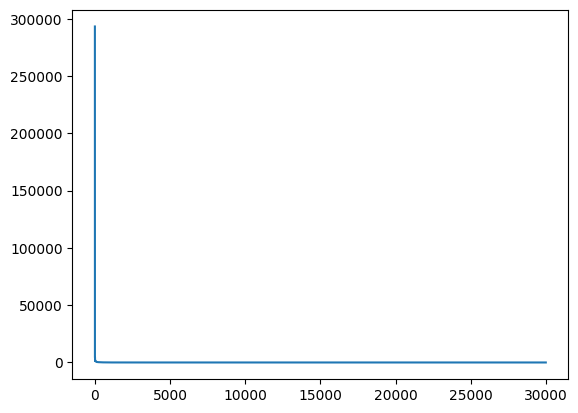

In [8]:
# gradient descent
f1 = gd(J, df, X0, 1./L, numb_iter=N)
plt.plot(f1[0])

# Exercício 3: Método do gradiente acelerado

Construa uma função `accel_gd(J, df, x0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `y_0=x0` e $t_0=1$:
\begin{align*}
X_{k+1}&:= Y_k - la\nabla f(Y_k),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
Y_{k+1} &:= X_{k+1} + \frac{t_{k}-1}{t_{k+1}}(X_{k+1}-X_{k}).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $Y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L` com `L=30000`.

In [36]:
#Escreva código aqui
def accel_gd(J, df, x0, la, numb_iter):
    # Descompactamos X0
    U, V = x0  
    # Setamos uma cópia para U e V
    Y_U, Y_V = U.copy(), V.copy()
    # Setamos t como 1 
    t = 1 
    grad_norms = []

    for k in range(numb_iter):
        # Calculamos o gradiente
        dU, dV = df(Y_U, Y_V, Y)

        # Calculamos a norma
        grad_norm = np.sqrt(J(dU)*2 + J(dV)*2)
        grad_norms.append(float(grad_norm))

        # Atualizamos o iterado
        X_U = Y_U - la * dU
        X_V = Y_V - la * dV

        # Atualizamos t_k como necessário
        t_next = (1 + np.sqrt(1 + 4 * t**2)) / 2

        # Atualizamos com o momento
        Y_U = X_U + ((t - 1) / t_next) * (X_U - U)
        Y_V = X_V + ((t - 1) / t_next) * (X_V - V)

        # Setamos a próxima iteração
        U, V = X_U, X_V 
        t = t_next 

    return grad_norms, (Y_U, Y_V)

In [37]:
L = 30000

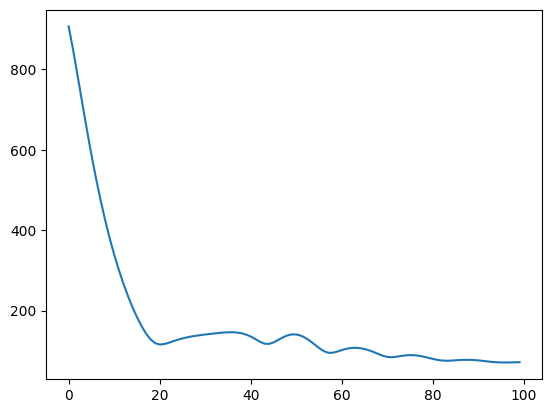

In [38]:
# Nesterov accelerated gradient descent

f2 = accel_gd(J, df, X0, 1./L, numb_iter=100)
plt.plot(f2[0])

# Exercício 4: Adagrad-Norm

Construa uma função `ad_grad_norm(J, df, x0, b0=0.5, eta=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, parametros positivos `b0` e `eta` e o número de iterações `numb_iter` e implementa o método Adagrad-Norm iniciando de `x0`:
\begin{align*}
X_{k+1}&:= X_k - \frac{\eta}{\sqrt{b_0^2 + \sum_{j=1}^k\Vert\nabla f(X_j)\Vert_2^2}} \nabla f(X_k).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `b0=0.5` e `eta=1`.

In [30]:
#Escreva código aqui
def ad_grad_norm(J, df, X0, b0, eta, numb_iter=N):
    # Descompactamos X0
    U, V = X0[0].copy(), X0[1].copy()

    grad_norms = []
    # Precisamos começar com b0^2
    accumulated_norm = b0**2

    for i in range(numb_iter):
        # Calculamos o gradiente em (U, V)
        dU, dV = df(U, V, Y)

        # Calcula a norma do gradiente atual
        grad_norm = np.sqrt(J(dU)**2 + J(dV)**2)
        grad_norms.append(float(grad_norm))

        # Atualizando o somatório
        accumulated_norm += grad_norm**2

        # Aplica a operação para atualizar nosso U
        adaptive_step = eta / np.sqrt(accumulated_norm)
        U -= adaptive_step * dU
        V -= adaptive_step * dV

    return grad_norms, (U, V)

In [32]:
# Adagrad-Norm
f3 = ad_grad_norm(J, df, X0, b0=0.5, eta=1, numb_iter=N)
plt.plot(f3[0])

KeyboardInterrupt: 

# Exercício 5: Adam

Construa uma função `adam(J, df, x0, alpha, beta1, beta2, epsilon, numb_iter)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, parametros positivos `alpha`, `beta1`, `beta2`, `epsilon` e o número de iterações `numb_iter` e implementa o método Adam iniciando de `x0`, $m_0=0$, $v_0=0$ e $k=0$: para cada $j$ézima coordenada:
\begin{align*}
m_{k+1}[j] &:= \beta_1\cdot m_{k}[j] + (1-\beta_1)\cdot\nabla f(X_k)[j],\\
v_{k+1}[j] &:= \beta_2\cdot v_{k}[j] + (1-\beta_2)\cdot(\nabla f(X_k)[j])^2,\\
\hat m_{k+1}[j] &:= \frac{1}{1-\beta_1^{k+1}}m_{k+1}[j],\\
\hat v_{k+1}[j] &:= \frac{1}{1-\beta_2^{k+1}}v_{k+1}[j],\\
X_{k+1}[j] &:= X_{k}[j] - \frac{\alpha}{\sqrt{\hat v_{k+1}[j]} + \epsilon}\hat m_{k+1}[j].
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `alpha=0.001`, `beta1=0.9`, `beta2=0.999`, `epsilon=10**(-8)`. 

In [ ]:
#Escreva código aqui
def adam(J, df, X0, alpha, beta1, beta2, epsilon, numb_iter):
    # Descompactamos X0
    U, V = X0[0].copy(), X0[1].copy()

    # Pegamos m_U e m_V, bem como v_u e v_V
    m_U, m_V = np.zeros_like(U), np.zeros_like(V)
    v_U, v_V = np.zeros_like(U), np.zeros_like(V)
    # Lista para guardar os gradientes
    grad_norms = []

    for k in range(numb_iter):
        # Calculamos o gradiente
        dU, dV = df(U, V, Y)

        # Atualizamos m_k
        m_U = beta1 * m_U + (1 - beta1) * dU
        m_V = beta1 * m_V + (1 - beta1) * dV

        # Atualiza v_k
        v_U = beta2 * v_U + (1 - beta2) * (dU ** 2)
        v_V = beta2 * v_V + (1 - beta2) * (dV ** 2)

        # atualizamos m_k_chapeu e v_k_chapeu
        m_U_chapeu = m_U / (1 - beta1 ** (k + 1))
        m_V_chapeu = m_V / (1 - beta1 ** (k + 1))
        v_U_chapeu = v_U / (1 - beta2 ** (k + 1))
        v_V_chapeu = v_V / (1 - beta2 ** (k + 1))

        # Atualiza X_k
        U -= alpha * m_U_chapeu / (np.sqrt(v_U_chapeu) + epsilon)
        V -= alpha * m_V_chapeu / (np.sqrt(v_V_chapeu) + epsilon)

        # Calcula e armazena a norma do gradiente
        grad_norm = np.sqrt(J(dU) ** 2 + J(dV) ** 2)
        grad_norms.append(float(grad_norm))

    return grad_norms, (U, V)

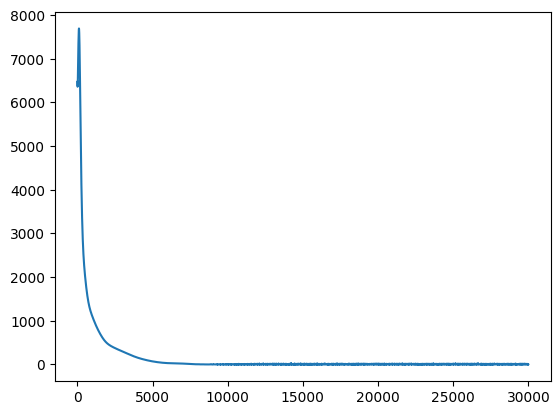

In [17]:
# Adam
f4 = adam(J, df, X0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8), numb_iter=N)
plt.plot(f4[0])

# Exercício 6: 

Implemente num mesmo gráfico os erros $\Vert\nabla f(X_k)\Vert$ de cada método em função no número de iterações.

In [26]:
import json
graphs = {}
graphs["GD"] = f1[0]
graphs["Nesterov"] = f2[0]
graphs["AdaGrad_Norm"] = f3[0]
graphs["Adam"] = f4[0]

with open("results.json", "w") as json_file:
    json.dump(graphs, json_file)

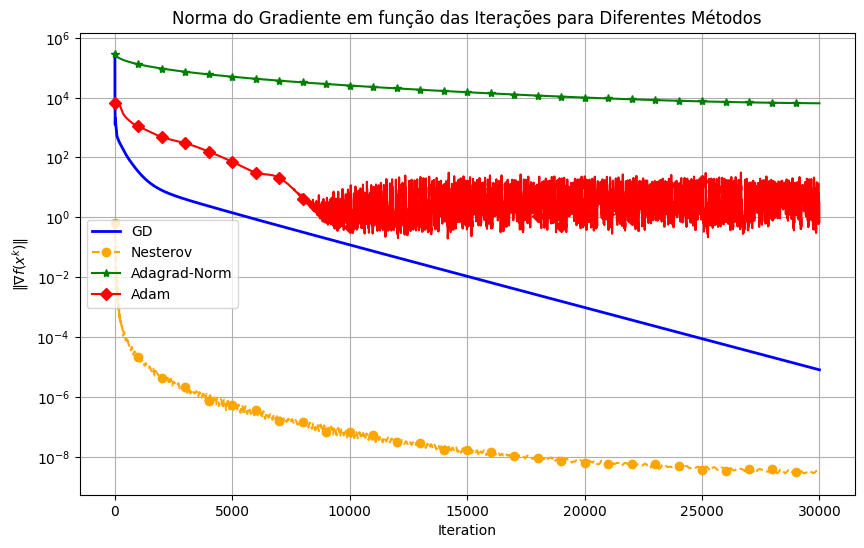

In [27]:
#Escreva código aqui
with open("results.json", "r") as json_file:
    plots = json.load(json_file)

plt.figure(figsize=(10, 6))

# Chamamos cada um dos f's já calculados
plt.plot(plots["GD"], label="GD", color="blue", linewidth=2)
plt.plot(plots["Nesterov"], label="Nesterov", color="orange", linestyle='--', marker='o', markevery=1000)
plt.plot(plots["AdaGrad_Norm"], label="Adagrad-Norm", color="green", linestyle='-', marker='*', markevery=1000)
plt.plot(plots["Adam"], label="Adam", color="red", linestyle='-', marker='D', markevery=1000)

# Setando o gráfico
plt.xlabel("Iteration")
plt.ylabel(r"$\Vert \nabla f(x^k) \Vert$")
plt.yscale("log")  # Escala logarítmica para melhor visualização
plt.title("Norma do Gradiente em função das Iterações para Diferentes Métodos")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Exercício 7:

Experimente com os hyper-parâmetros de Adagrad-Norm e Adam para ver se eles podem chegar perto ou superar a performance de GD e Nesterov. Plote o gráfico como no Exercício 6. 

In [20]:
# Recentemente no meu field project, utilizei uma biblioteca chamada optuna e acredito que ela se encaixe no contexto
# utilizarei o optuna para otimizar a escolha de hiperparâmetros, e depois armazenarei num json os resultados
import optuna


def objective_adam(trial, Y, U0, V0, J, df, numb_iter=30000):
    # Para o optuna, precisaremos sugerir ranges para testar
    alpha = trial.suggest_float('alpha', 1e-8, 1e-3, log = True)
    beta1 = trial.suggest_float('beta1', 0.8, 0.99)
    beta2 = trial.suggest_float('beta2', 0.9, 0.999)
    X0 = (U0.copy(), V0.copy())
    
    # Rodamos o adam
    grad_norms, (U_final, V_final) = adam(J, df, X0, alpha=alpha, beta1=beta1, beta2=beta2, epsilon=10**(-8), numb_iter=numb_iter)

    # Pegamos o último erro
    final_error = grad_norms[-1]
    
    # Return the final error as the objective to minimize
    return final_error

def objective_adagrad_norm(trial, Y, U0, V0, J, df, numb_iter=30000):
    # Mesmo procedimento de antes
    eta = trial.suggest_float('eta', 1e-2, 2.0, log = True)
    b0 = trial.suggest_float('b0', 1e-2, 1.0, log = True)
    X0 = (U0.copy(), V0.copy())
    
    # Rodamos com o selecionado
    grad_norms, (U_final, V_final) = ad_grad_norm(J, df, X0, b0=b0, eta=eta, numb_iter=numb_iter)

    # Pegamos o último erro
    final_error = grad_norms[-1]
    
    return final_error

def optuna_search_optimizers(Y, U0, V0, J, df, numb_iter=30000, n_trials=10):
    # Criamos um estudo para minimizar
    adam_study = optuna.create_study(direction="minimize")
    adagrad_norm_study = optuna.create_study(direction="minimize")

    # Rodamos a otimização
    print("Starting Optuna search for Adam...")
    adam_study.optimize(lambda trial: objective_adam(trial, Y, U0, V0, J, df, numb_iter), n_trials=n_trials)

    print("Starting Optuna search for AdaGrad-Norm...")
    adagrad_norm_study.optimize(lambda trial: objective_adagrad_norm(trial, Y, U0, V0, J, df, numb_iter), n_trials=n_trials)
    
    # Guardamos e retornamos os melhores resultados
    results = {
        "Adam": {
            "best_params": adam_study.best_params,
            "best_value": adam_study.best_value
        },
        "AdaGrad_Norm": {
            "best_params": adagrad_norm_study.best_params,
            "best_value": adagrad_norm_study.best_value
        }
    }
    
    return results

In [22]:
# Rodamos e guardamos o optimizer num json
results = optuna_search_optimizers(Y, U0, V0, J, df, numb_iter=8000, n_trials=10)
with open("optuna_results.json", "w") as json_file:
    json.dump(results, json_file)

[I 2024-11-11 18:04:43,486] A new study created in memory with name: no-name-2ba3cb83-99f0-4dd8-a6c5-b4728a752ce4
[I 2024-11-11 18:04:43,487] A new study created in memory with name: no-name-fdfa5c09-863b-4ac5-bdb5-1a867d983579


Starting Optuna search for Adam...


[I 2024-11-11 18:04:58,881] Trial 0 finished with value: 4.950629450876765e-05 and parameters: {'alpha': 1.444304571874791e-08, 'beta1': 0.941293653697116, 'beta2': 0.9186300578464245}. Best is trial 0 with value: 4.950629450876765e-05.
[I 2024-11-11 18:05:14,324] Trial 1 finished with value: 0.5924876765751749 and parameters: {'alpha': 8.372308541108167e-05, 'beta1': 0.8859235384908009, 'beta2': 0.9708358890208094}. Best is trial 0 with value: 4.950629450876765e-05.
[I 2024-11-11 18:05:29,669] Trial 2 finished with value: 0.00047985724158405895 and parameters: {'alpha': 4.4009817205237995e-07, 'beta1': 0.9848625679697045, 'beta2': 0.9516334914270963}. Best is trial 0 with value: 4.950629450876765e-05.
[I 2024-11-11 18:05:45,062] Trial 3 finished with value: 0.03287674861079626 and parameters: {'alpha': 4.1381327665579456e-06, 'beta1': 0.9050673315591967, 'beta2': 0.9650697640458675}. Best is trial 0 with value: 4.950629450876765e-05.
[I 2024-11-11 18:06:00,432] Trial 4 finished with v

Starting Optuna search for AdaGrad-Norm...


[I 2024-11-11 18:07:29,484] Trial 0 finished with value: 1.737749176794236e-08 and parameters: {'eta': 0.2284463580973617, 'b0': 0.056744576700260105}. Best is trial 0 with value: 1.737749176794236e-08.
[I 2024-11-11 18:07:43,630] Trial 1 finished with value: 1.559507935322012e-07 and parameters: {'eta': 0.7008123371843845, 'b0': 0.16165283750555873}. Best is trial 0 with value: 1.737749176794236e-08.
[I 2024-11-11 18:07:58,489] Trial 2 finished with value: 8.457556909866021e-08 and parameters: {'eta': 0.831488803180701, 'b0': 0.6383980946719917}. Best is trial 0 with value: 1.737749176794236e-08.
[I 2024-11-11 18:08:13,373] Trial 3 finished with value: 1.4923583625109166e-09 and parameters: {'eta': 0.01402047298607177, 'b0': 0.2834158545354131}. Best is trial 3 with value: 1.4923583625109166e-09.
[I 2024-11-11 18:08:28,173] Trial 4 finished with value: 7.306713214787807e-08 and parameters: {'eta': 0.46620510718213143, 'b0': 0.10827502400756008}. Best is trial 3 with value: 1.492358362

In [ ]:
# Carregamos os dados do json
with open("optuna_results.json", "r") as json_file:
    loaded_results = json.load(json_file)

adagrad_param = loaded_results["AdaGrad_Norm"]["best_params"]
adam_param = loaded_results["Adam"]["best_params"]
print(adagrad_param, adam_param)

{'eta': 0.062002060688563225, 'b0': 0.5489497084022434} {'alpha': 7.967861018099969e-07, 'beta1': 0.8995285920070648, 'beta2': 0.9200546372473754}


In [ ]:
# Rodamos a otimização
f3_optimized = ad_grad_norm(J, df, X0, b0=adagrad_param["b0"], eta=adagrad_param["eta"], numb_iter=30000)
f4_optimized =  adam(J, df, X0, alpha=adam_param["alpha"], beta1=adam_param["beta1"], beta2=adam_param["beta2"], epsilon=10**(-8), numb_iter=30000)

In [ ]:
graphs = {}
graphs["AdaGrad_Norm_best"] = f3_optimized[0]
graphs["Adam_best"] = f4_optimized[0]

with open("results_opt.json", "w") as json_file:
    json.dump(graphs, json_file)

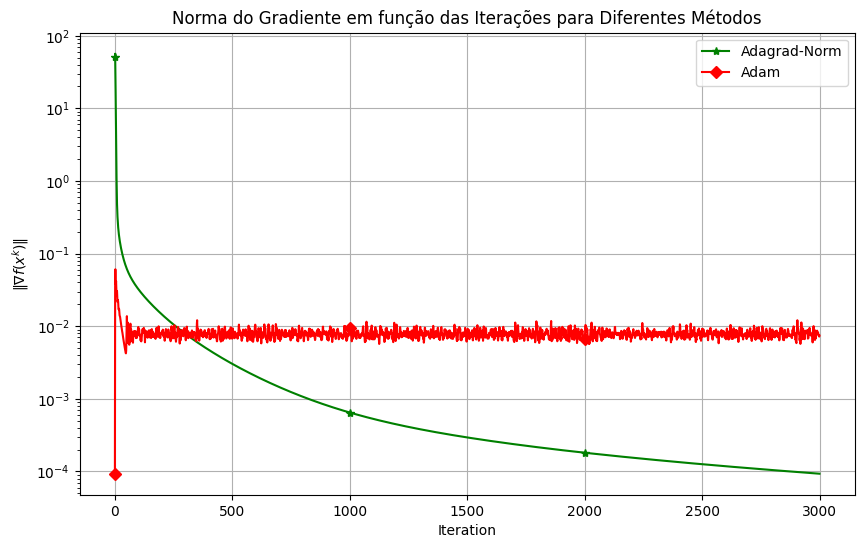

In [ ]:
#Escreva código aqui
# pegando os valores 
with open("results.json", "r") as json_file:
    plots_best = json.load(json_file)

# Plotando
plt.figure(figsize=(10, 6))

# Chamamos cada um dos f's já calculados
plt.plot(plots["GD"], label="GD", color="blue", linewidth=2)
plt.plot(plots["Nesterov"], label="Nesterov", color="orange", linestyle='--', marker='o', markevery=1000)
plt.plot(plots_best["AdaGrad_Norm_best"], label="Adagrad-Norm", color="green", linestyle='-', marker='*', markevery=1000)
plt.plot(plots_best["Adam_best"], label="Adam", color="red", linestyle='-', marker='D', markevery=1000)

# Setando o gráfico
plt.xlabel("Iteration")
plt.ylabel(r"$\Vert \nabla f(x^k) \Vert$")
plt.yscale("log")  # Escala logarítmica para melhor visualização
plt.title("Norma do Gradiente em função das Iterações para Diferentes Métodos")
plt.legend(loc="best")
plt.grid(True)
plt.show()